In [1]:
# checking for tensorflow devices
from tensorflow.python.client import device_lib
for d in device_lib.list_local_devices():
    print(d.name, d.physical_device_desc)

/device:CPU:0 
/device:GPU:0 device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1b.0, compute capability: 7.0
/device:GPU:1 device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1c.0, compute capability: 7.0
/device:GPU:2 device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1d.0, compute capability: 7.0
/device:GPU:3 device: 3, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0


In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras import optimizers
import keras.backend as K
from keras.utils import to_categorical, multi_gpu_model
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator
from sklearn.datasets import load_iris
from keras.datasets import fashion_mnist, mnist, cifar100
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

np.set_printoptions(suppress=True)
%matplotlib inline

Using TensorFlow backend.


In [3]:
# dataset generators for test and train
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# dataset generators for test and train
train_generator = train_datagen.flow_from_directory(
        'kaggle/dogs-vs-cats/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        'kaggle/dogs-vs-cats/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=False)

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [5]:
# all images are scaled to the same size
input_shape = (150, 150, 3)

In [6]:
# cnn model
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape, name='L0'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, (3,3), activation='relu', name='L1'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(128, (3,3), activation='relu', name='L2'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())         
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.2))                  
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L0 (Conv2D)                  (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
L1 (Conv2D)                  (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
L2 (Conv2D)                  (None, 34, 34, 128)       73856     
__________

In [7]:
# making the sequential model run across multiple GPUs
opt = optimizers.SGD(lr=0.001)

parallel_model = multi_gpu_model(model, 4)
parallel_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
L0_input (InputLayer)           (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 150, 150, 3)  0           L0_input[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 150, 150, 3)  0           L0_input[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 150, 150, 3)  0           L0_input[0][0]                   
__________________________________________________________________________________________________
lambda_4 (

In [8]:
# number of images per batch, and total images
train_generator.batch_size, train_generator.samples

(32, 17500)

In [9]:
# number of batches in epoch
# added 2x for training to get more random samples
train_batches_per_epoch = int(train_generator.samples / train_generator.batch_size) * 2
validation_batches_per_epoch = int(validation_generator.samples / validation_generator.batch_size)
train_batches_per_epoch, validation_batches_per_epoch

(1092, 234)

In [10]:
# get a batch and its classes
batch = train_generator.next()
batch[1]

array([0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1.],
      dtype=float32)

In [11]:
# there are 32, 150x150, 3-channel images in this batch
batch[0].shape

(32, 150, 150, 3)

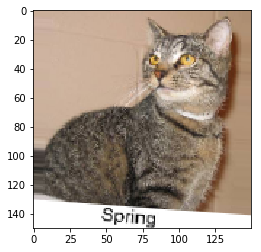

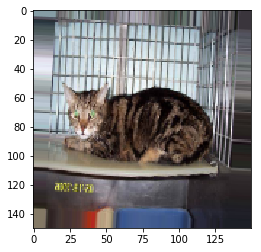

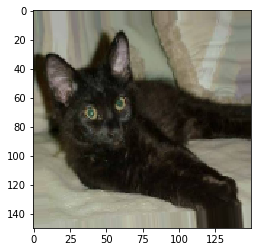

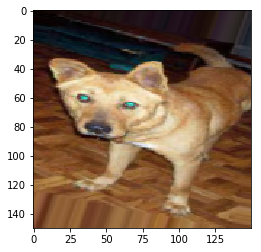

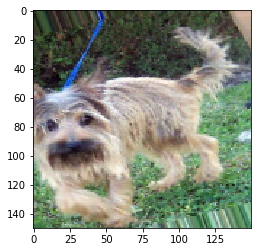

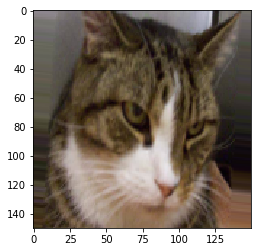

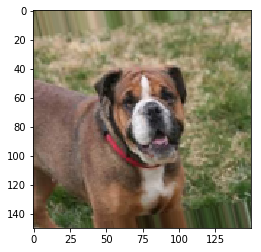

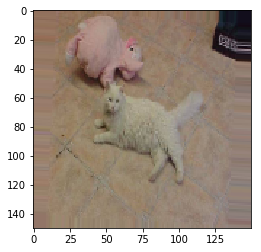

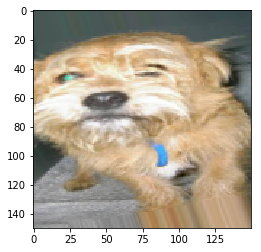

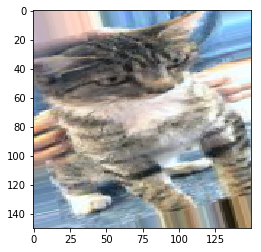

In [12]:
# show 10 sample from the batch
for i in range(10):
    plt.imshow(batch[0][i])
    plt.show()

In [13]:
history = parallel_model.fit_generator(
        train_generator,
        steps_per_epoch=train_batches_per_epoch,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=validation_batches_per_epoch,
        workers=32,
        use_multiprocessing=True)

Epoch 1/30
1092/1092 [==============================] - 59s 54ms/step - loss: 0.6142 - acc: 0.6877 - val_loss: 0.5847 - val_acc: 0.7019
Epoch 2/30
1092/1092 [==============================] - 55s 51ms/step - loss: 0.5026 - acc: 0.7537 - val_loss: 0.5027 - val_acc: 0.7584
Epoch 3/30
1092/1092 [==============================] - 55s 51ms/step - loss: 0.4686 - acc: 0.7754 - val_loss: 0.4716 - val_acc: 0.7804
Epoch 4/30
1092/1092 [==============================] - 56s 51ms/step - loss: 0.4442 - acc: 0.7904 - val_loss: 0.4577 - val_acc: 0.7873
Epoch 5/30
1092/1092 [==============================] - 56s 51ms/step - loss: 0.4208 - acc: 0.8041 - val_loss: 0.4408 - val_acc: 0.7979
Epoch 6/30
1092/1092 [==============================] - 55s 50ms/step - loss: 0.4083 - acc: 0.8121 - val_loss: 0.4160 - val_acc: 0.8105
Epoch 7/30
1092/1092 [==============================] - 55s 50ms/step - loss: 0.3938 - acc: 0.8193 - val_loss: 0.4073 - val_acc: 0.8152
Epoch 8/30
1092/1092 [==========================

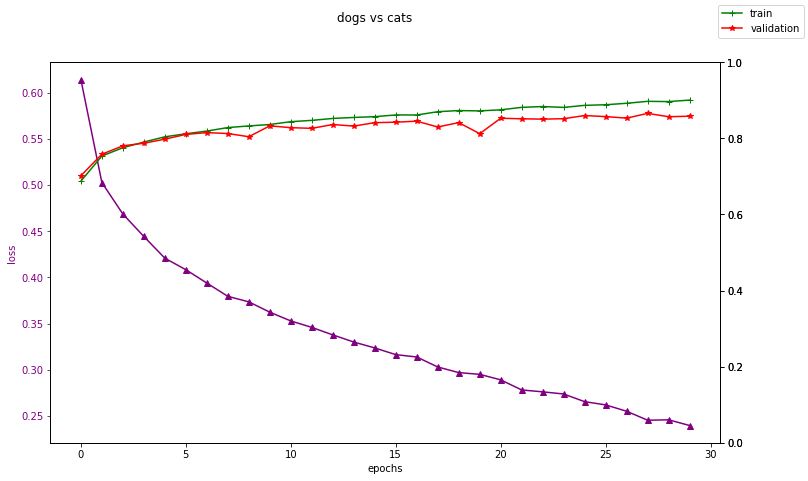

In [14]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(history.epoch, history.history['loss'], marker='^', color='purple')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
plt.plot(history.epoch, history.history['acc'], marker='+', color='green', label='train')
ax2.set_ylim(0,1)

ax3 = ax1.twinx()
plt.plot(history.epoch, history.history['val_acc'], marker='*', color='red', label='validation')
ax3.set_ylim(0,1)

fig.suptitle('dogs vs cats');
fig.legend();

In [15]:
# gettng y and y_hat
probabilities = model.predict_generator(validation_generator, workers=32, use_multiprocessing=True)
y_hat = probabilities > 0.5
y = validation_generator.classes

In [16]:
# classes
validation_generator.class_indices

{'cats': 0, 'dogs': 1}

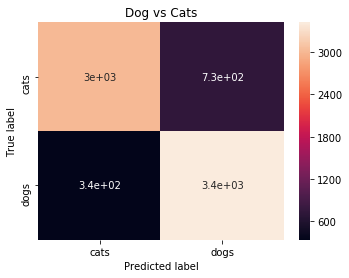

In [17]:
# confusion matrix
klasses = validation_generator.class_indices.keys()
cm = confusion_matrix(y, y_hat)
cm_df = pd.DataFrame(cm,
                     index = klasses, 
                     columns = klasses)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Dog vs Cats')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()